In [1]:
import csv
import time
import datetime
import warnings
import numpy as np
import utils as ut
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from itertools import product, groupby
from sklearn.impute import SimpleImputer
from sklearn import feature_selection as fs
from sklearn.decomposition import KernelPCA
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, average_precision_score, make_scorer, precision_recall_curve, auc

### Datasets

In [2]:
datasets = dict()
for dataset_name in ut.corpus_1_mat + ut.corpus_2_arff + ut.corpus_3_bioconductor + ut.corpus_4_microbiomicdata:
    datasets[dataset_name] = ut.make_loader(dataset_name)

Some information about the chosen datasets

In [3]:
for dataset_name in ut.corpus_1_mat + ut.corpus_2_arff + ut.corpus_3_bioconductor + ut.corpus_4_microbiomicdata:
    X, y = datasets[dataset_name]()
    desc = ut.describe_dataset(dataset_name, X, y)
    desc.update({'NumOfClasses': len(set(y))})
    print(desc)

{'DatasetName': 'ORL', 'NumOfSamples': 400, 'OriginalNumOfFeatures': 1024, 'NumOfClasses': 40}
{'DatasetName': 'Carcinom', 'NumOfSamples': 174, 'OriginalNumOfFeatures': 9182, 'NumOfClasses': 11}
{'DatasetName': 'colon', 'NumOfSamples': 62, 'OriginalNumOfFeatures': 2000, 'NumOfClasses': 2}
{'DatasetName': 'nci9', 'NumOfSamples': 60, 'OriginalNumOfFeatures': 9712, 'NumOfClasses': 9}
{'DatasetName': 'pixraw10P', 'NumOfSamples': 100, 'OriginalNumOfFeatures': 10000, 'NumOfClasses': 10}
{'DatasetName': 'CNS', 'NumOfSamples': 60, 'OriginalNumOfFeatures': 7129, 'NumOfClasses': 2}
{'DatasetName': 'Leukemia_3c', 'NumOfSamples': 72, 'OriginalNumOfFeatures': 7129, 'NumOfClasses': 3}
{'DatasetName': 'Lung', 'NumOfSamples': 203, 'OriginalNumOfFeatures': 12600, 'NumOfClasses': 5}
{'DatasetName': 'MLL', 'NumOfSamples': 72, 'OriginalNumOfFeatures': 12582, 'NumOfClasses': 3}
{'DatasetName': 'Ovarian', 'NumOfSamples': 253, 'OriginalNumOfFeatures': 15154, 'NumOfClasses': 2}
{'DatasetName': 'CLL', 'NumOfSa

### Preprocessing the Datasets

In [4]:
pipeline = Pipeline([
            ('SimpleImputer', SimpleImputer(strategy='median')),
            ('VarianceThreshold', VarianceThreshold(threshold=0.0)),
            ('PowerTransformer', PowerTransformer(method='yeo-johnson')),
])

for dataset_name in datasets:
    if not ut.is_preprocessed(dataset_name):
        X, y = datasets[dataset_name]()
        X = pipeline.fit_transform(X, y)
        y = LabelEncoder().fit_transform(y)
        ut.save_preprocessed(dataset_name, X, y)

The estimator class is a convenient class meant to wrap a feature selection algorithm and a k and provide a way to cross validate the feature selection and a classifier.

In [5]:
class Estimator(ClassifierMixin, BaseEstimator):
    def __init__(self, fsMethod, k):
        ClassifierMixin.__init__(self)
        BaseEstimator.__init__(self)

        self.fs_name = fsMethod
        self.feature_selector = ut.get_fs(fsMethod, k=k)
        self.k = k

        self.classes_ = None
        self.cv = None
        self.input_features = None
        self.fit_time = None
        self.inference_time = None
        
        
    def fit(self, clfMethod, X, y):
        X, y = check_X_y(X, y, accept_sparse=True)
        self.classes_ = unique_labels(y)
        self.cv = ut.get_cv_method(X.shape[0], y)[1]   # the callable part

        # if dataset contains more than 1000 features, using SelectKBest with f_classif
        if self.fs_name in ['MFMW', 'TRI_STAGE', 'MFMW_New'] and X.shape[1] > 1000:
            X = SelectKBest(fs.f_classif, k=1000).fit_transform(X, y)
        self.input_features = [f'Gen{i}' for i in range(X.shape[1])]

        pipeline = Pipeline([
            ('SelectKBest', SelectKBest(self.feature_selector, k=self.k)),
            ('Classifier', ut.get_classifier(clfMethod))
        ])

        scoring = {
            'ACC' : make_scorer(accuracy_score), 
            'MCC' : make_scorer(matthews_corrcoef), 
            'AUC' : make_scorer(ut.auc_scorer, classes=self.classes_),
            'PR_AUC' : make_scorer(ut.prauc_scorer, classes=self.classes_),
        }

        scoring_loocv = {
            'ACC' : make_scorer(accuracy_score), 
            'y_pred' : make_scorer(lambda y_test, y_pred: y_pred[0]), 
        }
        
        self.scores_ = cross_validate(pipeline, X, y, cv=self.cv, return_estimator=True,
                        scoring=scoring if self.cv.get_n_splits(X) != X.shape[0] else scoring_loocv, n_jobs=-1)
        self.fit_time = self.scores_['fit_time'].mean()
        self.inference_time = self.scores_['score_time'].mean()
        
        return self

    def get_feature_names_out(self):
        check_is_fitted(self, ['classes_', 'scores_'])
        scores = self.get_feature_scores_out()
        return [self.input_features[i] for i in np.argsort(scores)[::-1][:self.k]]
    
    def get_feature_scores_out(self):
        check_is_fitted(self, ['classes_', 'scores_'])
        pipelines = self.scores_['estimator']
        # return the mean of the feature scores
        feature_scores = np.zeros(len(self.input_features))
        for pipeline in pipelines:
            feature_scores += pipeline.named_steps['SelectKBest'].scores_
        return feature_scores // len(pipelines)
    
    def score(self, X, y):
        check_is_fitted(self, ['classes_', 'scores_'])
        X, y = check_X_y(X, y, accept_sparse=True)

        # if self.cv is LeaveOneOut
        if self.cv.get_n_splits(X) == X.shape[0]:
            return {'ACC': self.scores_['test_ACC'].mean(),
                    'MCC': matthews_corrcoef(y, self.scores_['test_y_pred']),
                    'AUC': ut.auc_scorer(y, self.scores_['test_y_pred'], classes=self.classes_),
                    'PR_AUC': ut.prauc_scorer(y, self.scores_['test_y_pred'], classes=self.classes_)}
        else:
            # return only key, value pairs in self.scores_ where the key starts in 'test_'
            return {k[5:]: np.mean(v) for k, v in self.scores_.items() if k.startswith('test_')}

In [6]:
OVERWRITE = False

if OVERWRITE:
    ut.delete_data()

## Parts B&C

In the following cell we run all of the feature selection algorithms with all of the possible configurations for the classifier and k, on all datasets.

In [ ]:
fsMethods = ['MRMR', 'FDR', 'RFE_SVM', 'ReliefF', 'MFMW', 'TRI_STAGE', 'MFMW_New']
clfMethods = ['KNN', 'SVM', 'NB', 'RF', 'LogReg']
ks = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 50, 100]

for dataset in datasets:
    X, y = ut.load_preprocessed(dataset)
    data_info = ut.describe_dataset(dataset, X, y)
    print(data_info)
    for fsMethod, k in product(fsMethods, ks):
        print(fsMethod, k)
        estimator = Estimator(fsMethod, min(k, X.shape[1]))
        for clf in clfMethods:
            print(f'\t{clf}')
            exper_info = {
                'FilteringAlgorithm': fsMethod,
                'LearningAlgorithm' : clf,
                'NumFeaturesSelected(K)' : k,
                'CVMethod' : ut.get_cv_method(X.shape[0])[0],
                'Fold' : ut.get_cv_method(X.shape[0])[1].get_n_splits(X)
            }
            
            row = {**data_info, **exper_info} 
            if ut.row_exists(row):
                print("exists, skipping...")
                continue
            
            try:
                estimator.fit(clf, X, y)
                scores = estimator.score(X, y)
                for score_type, score_val in scores.items():
                    pred_info = {
                        'MeasureType': score_type,
                        'MeasureVal' : score_val,
                        'ListOfFeaturesNames' : estimator.get_feature_names_out(),
                        'ListOfFeaturesScores' : estimator.get_feature_scores_out(),
                        'FeatureSelectionTime' : estimator.fit_time,
                        'FitTime' : estimator.fit_time,
                        'InferenceTime' : estimator.inference_time
                    }
                
                    prediction_row = { **row, **pred_info }
                    ut.append_row(prediction_row)
                
            except Exception as e:
                print('Failed! see log.txt for more info...')
                with open('log.txt', 'a') as file:
                    date_time = datetime.datetime.now()
                    file.write('[{}] - {} - {} - {} - {} - {}\n'.format(
                                date_time.strftime("%Y-%m-%d %H:%M"), data_info["DatasetName"],
                                fsMethod, clf, k, str(e)))
ut.append_row(finish=True)

We try to evaluate how well the MFMW_New algorithm performed compared to the original MFMW

ACC 378 296
MCC 381 312
AUC 376 313
PR_AUC 378 320


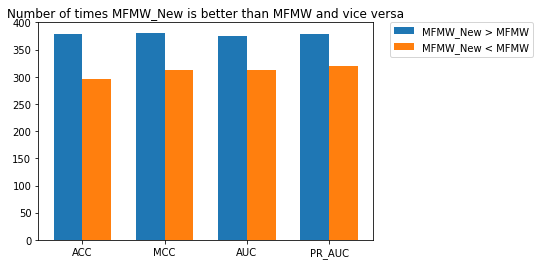

In [ ]:
# get all rows that have MFMW_New in FilteringAlgorithm column from data.csv file
df = pd.read_csv('data.csv')
df.dropna()
df_mfmw_new = df[df['FilteringAlgorithm'] == 'MFMW_New']
df_mfmw = df[df['FilteringAlgorithm'] == 'MFMW']
# for each measure count how many times MFMW_New is better than MFMW and vice versa
counts = {}
for measure in ['ACC', 'MCC', 'AUC', 'PR_AUC']:
    mfmw_new_scores = df_mfmw_new[df_mfmw_new['MeasureType'] == measure]['MeasureVal'].values
    mfmw_scores = df_mfmw[df_mfmw['MeasureType'] == measure]['MeasureVal'].values
    counts[measure] = ((mfmw_new_scores > mfmw_scores).sum(), (mfmw_new_scores < mfmw_scores).sum())
    print(measure, np.sum(mfmw_new_scores > mfmw_scores), np.sum(mfmw_new_scores < mfmw_scores))

# plot a histogram that shows the number of times MFMW_New is better than MFMW and vice versa side by side for all measures in the same chart
fig, ax = plt.subplots()
width = 0.35
x = np.arange(len(counts))
ax.bar(x - width/2, [counts[measure][0] for measure in counts], width, label='MFMW_New > MFMW')
ax.bar(x + width/2, [counts[measure][1] for measure in counts], width, label='MFMW_New < MFMW')
ax.set_xticks(x)
ax.set_xticklabels([measure for measure in counts])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Number of times MFMW_New is better than MFMW and vice versa')
plt.show()